This notebook briefly outlines how to get lightcurve data for particular events from different microlensing alert webpages.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import requests
import pandas as pd
import ftplib
from io import BytesIO
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numexpr as ne
import matplotlib.pyplot as plt

## MOA

http://www.massey.ac.nz/~iabond/moa/alert2021/display.php?id=gb4-R-5-47895


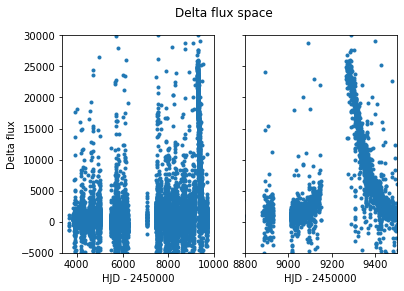

/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


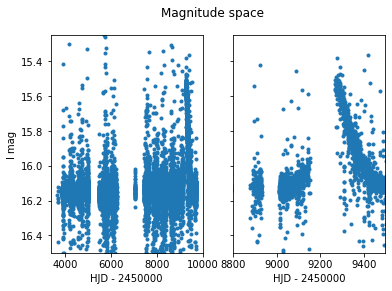

In [2]:
year = "2022"
event = "gb8-R-3-40286"

year = "2021"
event = "gb4-R-5-47895"

# Scrape alert website for magnitude and flux offsets.
url = "http://www.massey.ac.nz/~iabond/moa/alert" + year + "/display.php?id=" + event
print(url)
response = urlopen(url)
html = response.read()
response.close()
soup = BeautifulSoup(html,"html.parser")

# Get the magnitude and flux offsets.
foo = soup.find('b').next_sibling
moff = foo.split('=')[1].split('-')[0].strip(' ')
bah = soup.find('sub').next_sibling
foff = bah.split('+')[1].split(')')[0].strip(' ')

# Now convert these into floats
m = ne.evaluate(moff)
f = ne.evaluate(foff)

# Now scrape the .dat file into a pandas dataframe.
url = "https://www.massey.ac.nz/~iabond/moa/alert" + year + "/fetchtxt.php?path=moa/ephot/phot-" + event + ".dat"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), 
                 delim_whitespace=True, skiprows=11, skipfooter=1, header=None, engine='python', 
                 names=['hjd', 'delta_flux', 'flux', 'foo1', 'foo2', 'foo3', 'foo4', 'foo5'])

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(df['hjd'] - 2450000, df['delta_flux'], '.')
ax[1].plot(df['hjd'] - 2450000, df['delta_flux'], '.')
ax[1].set_xlim(8800, 9500)
ax[1].set_ylim(-5000, 30000)
ax[0].set_ylabel('Delta flux')
ax[0].set_xlabel('HJD - 2450000')
ax[1].set_xlabel('HJD - 2450000')
plt.suptitle('Delta flux space')
plt.show()

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(df['hjd'] - 2450000, m - 2.5*np.log10(df['delta_flux'] + f), '.')
ax[1].plot(df['hjd'] - 2450000, m - 2.5*np.log10(df['delta_flux'] + f), '.')
ax[1].set_xlim(8800, 9500)
ax[1].set_ylim(15.25, 16.5)
ax[0].set_ylabel('I mag')
ax[0].set_xlabel('HJD - 2450000')
ax[1].set_xlabel('HJD - 2450000')
ax[0].invert_yaxis()
plt.suptitle('Magnitude space')
plt.show()

In [3]:
# Why is there missing data???
url = "http://www.massey.ac.nz/~iabond/moa/alert2022/fetchtxt.php?path=moa/ephot/phot-gb8-R-3-40286.dat"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), delim_whitespace=True, skiprows=11, skipfooter=1, header=None, engine='python')

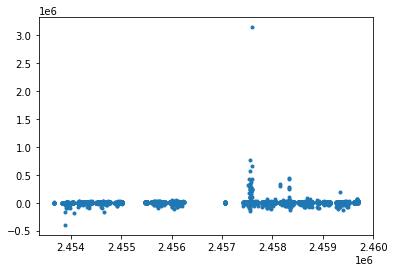

In [4]:
plt.plot(df.iloc[:,0], df.iloc[:,1], '.')

## OGLE

In [5]:
ftp = ftplib.FTP("ftp.astrouw.edu.pl")
ftp.login()
ftp.cwd("ogle/ogle4/ews/2019/blg-0002")

# Figure out how to write to array instead of file.
# Or maybe directly to SQL database?
# https://stackoverflow.com/questions/18772703/read-a-file-in-buffer-from-ftp-python
flo = BytesIO()
# ftp.retrbinary('RETR phot.dat', 
#                open('blg-0002.phot.dat', 'wb').write)
ftp.retrbinary('RETR phot.dat', flo.write)
flo.seek(0)
x = pd.read_fwf(flo, header=0, names=['HJD', 'mag', 'mag_err', 'see', 'sky'])

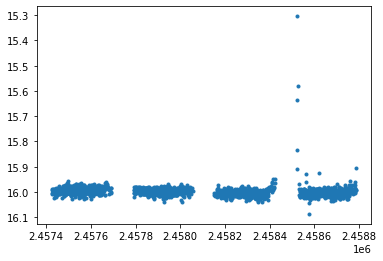

In [6]:
import matplotlib.pyplot as plt
plt.plot(x['HJD'], x['mag'], '.')
plt.gca().invert_yaxis()

## KMTNet

In [7]:
# How you can write out data from the KMTNet file into a pandas dataframe.
url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/data/KB220002/pysis/KMTA01_I.pysis"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), 
                 delim_whitespace=True, skiprows=1, header=None, 
                 names=['HJD', 'Delta_flux', 'flux_err', 'mag', 'mag_err', 'fwhm', 'sky', 'secz'])

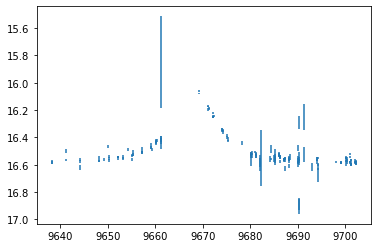

In [8]:
# Some plotting just to see.
plt.errorbar(df['HJD'], df['mag'], yerr=df['mag_err'], ls='none')
#plt.ylim(15.7, 16.25)
plt.gca().invert_yaxis()

In [9]:
# For KMTNet, get data from all the telescopes. But they're different for each page.
# So here is how you can get all the names of the files.
# (Do we really want to do this?)
url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0001"
print(url)
response = urlopen(url)
html = response.read()
response.close()
soup = BeautifulSoup(html,"html.parser")

links = soup.find_all('a', href=True)

# What is the difference between text and get_text?
print(links[3].get_text(separator=',').split(',')[:-2])

# Compare the output of a different alert:
url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0002"
print(url)
response = urlopen(url)
html = response.read()
response.close()
soup = BeautifulSoup(html,"html.parser")

links = soup.find_all('a', href=True)

# What is the difference between text and get_text?
print(links[3].get_text(separator=',').split(',')[:-2])

https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0001
['KMTA04_I.pysis', 'KMTC01_I.pysis', 'KMTC04_I.pysis', 'KMTC04_V.pysis', 'KMTS01_I.pysis', 'KMTS01_V.pysis', 'KMTS04_I.pysis']
https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0002
['KMTA01_I.pysis', 'KMTA01_V.pysis', 'KMTA41_I.pysis', 'KMTA41_V.pysis', 'KMTC01_I.pysis', 'KMTC01_V.pysis', 'KMTC41_I.pysis', 'KMTC41_V.pysis', 'KMTS01_I.pysis', 'KMTS01_V.pysis', 'KMTS41_I.pysis', 'KMTS41_V.pysis']
